In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [117]:
def plot_corrlation_matrix(corr_matrix: pd.DataFrame, position: str):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix - {position}')
    plt.show()

In [118]:
# constants
columns_of_interest_gk = ['assists', 'clean_sheets', 'creativity', 'difficulty', 'difficulty_difference', 'goals_conceded',
       'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_saved', 'saves', 'threat', 'total_points']
columns_of_interest_def = ['assists', 'clean_sheets', 'creativity', 'difficulty', 'difficulty_difference', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes',
       'own_goals', 'threat', 'total_points']
columns_of_interest_mid = ['assists', 'clean_sheets', 'creativity', 'difficulty',  'difficulty_difference',
       'goals_scored', 'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_missed', 'threat', 'total_points']
columns_of_interest_for= ['assists', 'creativity', 'difficulty', 'difficulty_difference',
       'goals_scored', 'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_missed', 'threat', 'total_points']

In [239]:
stats = pd.read_csv('../data/all_data.csv')
stats = stats.replace('GKP', 'GK')

How much to people play?

In [227]:
position_minutes = stats.groupby('position')['minutes'].agg(['mean', 'min', 'max'])
position_minutes

mean  min  max
position                     
DEF       31.984411    0   90
FWD       25.947423    0   90
GK        24.262667    0   90
GKP       21.386139    0   90
MID       29.804372    0   90

Mean number of minutes played is very low. Probably influenced by a proportion of data points that don't play at all.

In [236]:
print(f"Percentage of samples with 0 minutes: {round(100*(len(stats.query('minutes == 0')) / len(stats)), 1)}%")

Percentage of samples with 0 minutes: 57.8%


In [240]:
data_with_minutes = stats.query('minutes > 0')
position_minutes_new = data_with_minutes.groupby('position')['minutes'].agg(['mean', 'min', 'max'])
position_minutes_new

mean  min  max
position                     
DEF       78.024368    1   90
FWD       57.952657    1   90
GK        89.290688    1   90
MID       64.107022    1   90

These numbers don't seem surprising. Goalkeepers are rarely substituted, forward players are more likely to be subbed if they're struggling to score or get tired. If you are chasing the game and need a goal, the most likely sub to bring on is a striker.

Correlation analysis

In [120]:
forwards = stats.query('position == "FWD" and minutes > 0')
midfield = stats.query('position == "MID" and minutes > 0')
defence = stats.query('position == "DEF" and minutes > 0')
keepers = stats.query('position == "GK" and minutes > 0')

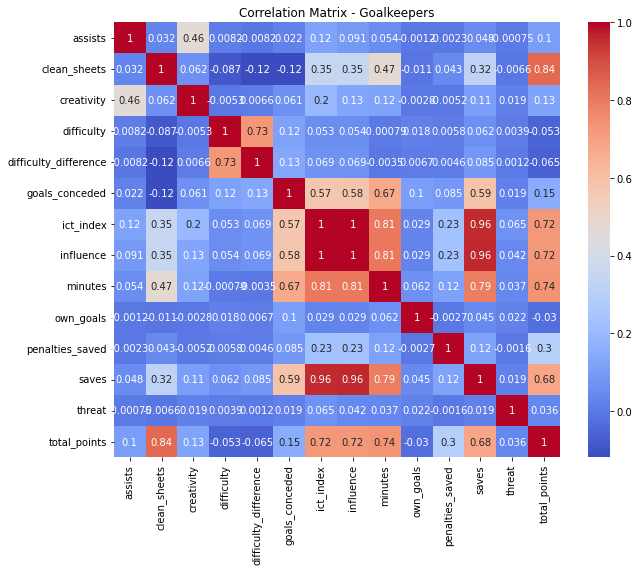

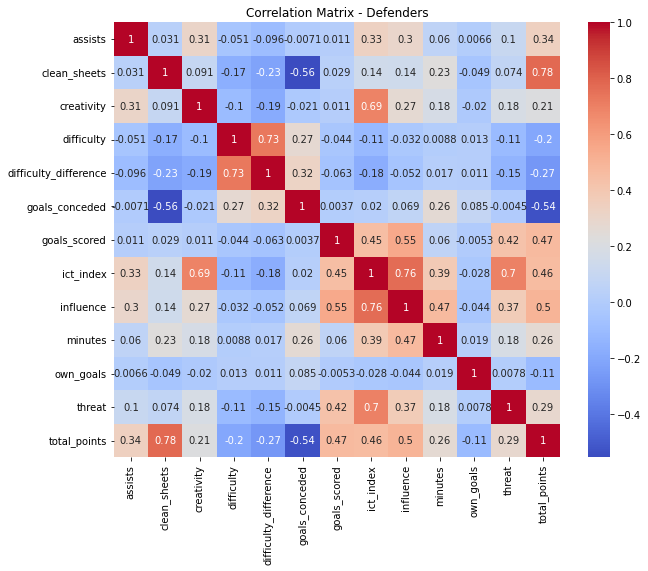

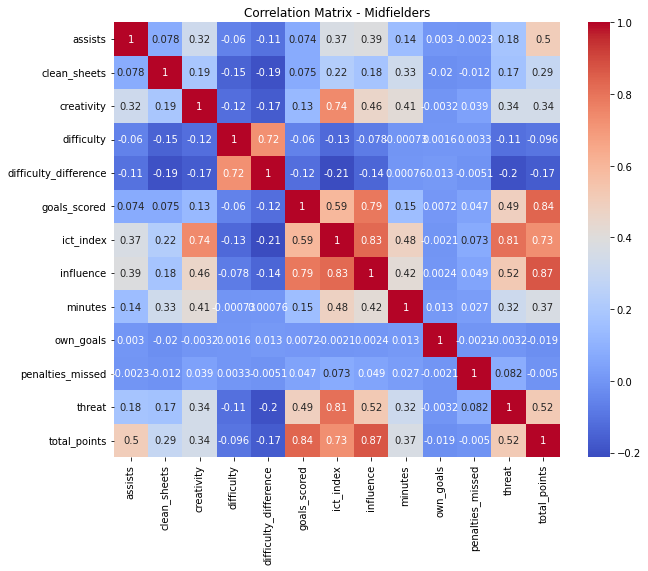

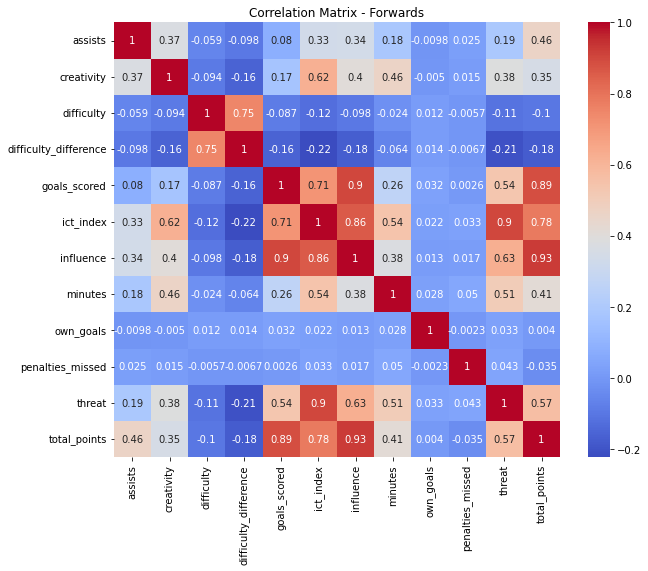

In [121]:
plot_corrlation_matrix(keepers[columns_of_interest_gk].corr(), 'Goalkeepers')
plot_corrlation_matrix(defence[columns_of_interest_def].corr(), 'Defenders')
plot_corrlation_matrix(midfield[columns_of_interest_mid].corr(), 'Midfielders')
plot_corrlation_matrix(forwards[columns_of_interest_for].corr(), 'Forwards')

## Importance of fixture difficulty for goals scores/clean sheets

In [176]:
def calculate_mean_and_ci(data: pd.DataFrame, metric: str, difficulty_type: str, difficulty: int, home_team: bool):
    if home_team:
        refined_data = data[data[f'team_h_{difficulty_type}'] == difficulty]
        metric_column = refined_data[f'team_h_{metric}']
    else:
        refined_data = data[data[f'team_a_{difficulty_type}'] == difficulty]
        metric_column = refined_data[f'team_a_{metric}']

    lower, upper = st.t.interval(alpha=0.95, df=len(metric_column)-1, 
              loc=np.mean(metric_column), 
              scale=st.sem(metric_column))
    
    return pd.DataFrame({difficulty_type: [difficulty], 'mean': [np.mean(metric_column)], 'ci_lower': [lower], 'ci_upper': [upper]})

In [216]:
def plot_bar_chart(metric_home, metric_away, title, xlabel, ylabel):
    labels = metric_home.difficulty if xlabel == 'Difficulty' else metric_home.difficulty_difference
    home_means = metric_home['mean']
    away_means = metric_away['mean']

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(15, 6))
    rects1 = ax.bar(x - width/2, home_means, width, yerr=[metric_home['mean']-metric_home['ci_lower'], metric_home['ci_upper']-metric_home['mean']], label='Home', capsize=5, color='skyblue')
    rects2 = ax.bar(x + width/2, away_means, width, yerr=[metric_away['mean']-metric_away['ci_lower'], metric_away['ci_upper']-metric_away['mean']], label='Away', capsize=5, color='salmon')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

Load data and create 'clean sheet' column for home and away sides

In [124]:
fixture_df = pd.read_csv('../data/all_seasons_fixtures.csv')
fixture_df['team_h_clean_sheet'] = fixture_df['team_a_score'] == 0
fixture_df['team_a_clean_sheet'] = fixture_df['team_h_score'] == 0

Calculate mean and confidence intervals

In [182]:
goals_scored_home_difficulty = pd.DataFrame()
goals_scored_away_difficulty = pd.DataFrame()
clean_sheets_home_difficulty = pd.DataFrame()
clean_sheets_away_difficulty = pd.DataFrame()
for difficulty in [2, 3, 4, 5]:
    goals_scored_home_difficulty = pd.concat([goals_scored_home_difficulty, calculate_mean_and_ci(fixture_df, 'score', 'difficulty', difficulty, True)])
    goals_scored_away_difficulty = pd.concat([goals_scored_away_difficulty, calculate_mean_and_ci(fixture_df, 'score', 'difficulty', difficulty, False)])
    clean_sheets_home_difficulty = pd.concat([clean_sheets_home_difficulty, calculate_mean_and_ci(fixture_df, 'clean_sheet', 'difficulty', difficulty, True)])
    clean_sheets_away_difficulty = pd.concat([clean_sheets_away_difficulty, calculate_mean_and_ci(fixture_df, 'clean_sheet', 'difficulty', difficulty, False)])

In [185]:
goals_scored_home_difficulty_diff = pd.DataFrame()
goals_scored_away_difficulty_diff = pd.DataFrame()
clean_sheets_home_difficulty_diff = pd.DataFrame()
clean_sheets_away_difficulty_diff = pd.DataFrame()
for difficulty in [-3, -2, -1, 0, 1, 2, 3]:
    goals_scored_home_difficulty_diff = pd.concat([goals_scored_home_difficulty_diff, calculate_mean_and_ci(fixture_df, 'score', 'difficulty_difference', difficulty, True)])
    goals_scored_away_difficulty_diff = pd.concat([goals_scored_away_difficulty_diff, calculate_mean_and_ci(fixture_df, 'score', 'difficulty_difference', difficulty, False)])
    clean_sheets_home_difficulty_diff = pd.concat([clean_sheets_home_difficulty_diff, calculate_mean_and_ci(fixture_df, 'clean_sheet', 'difficulty_difference', difficulty, True)])
    clean_sheets_away_difficulty_diff = pd.concat([clean_sheets_away_difficulty_diff, calculate_mean_and_ci(fixture_df, 'clean_sheet', 'difficulty_difference', difficulty, False)])

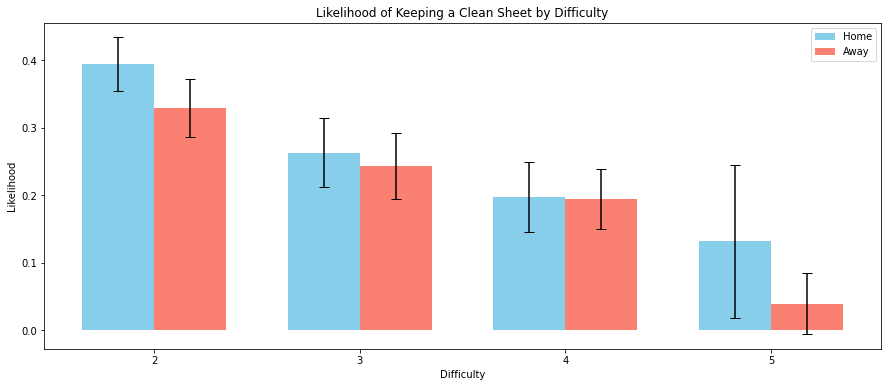

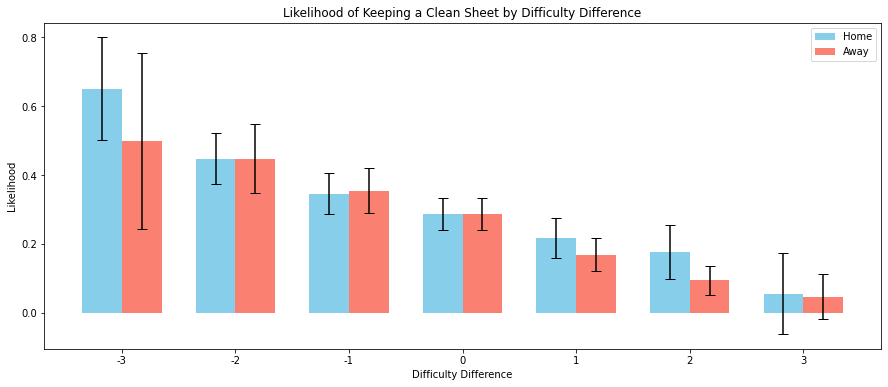

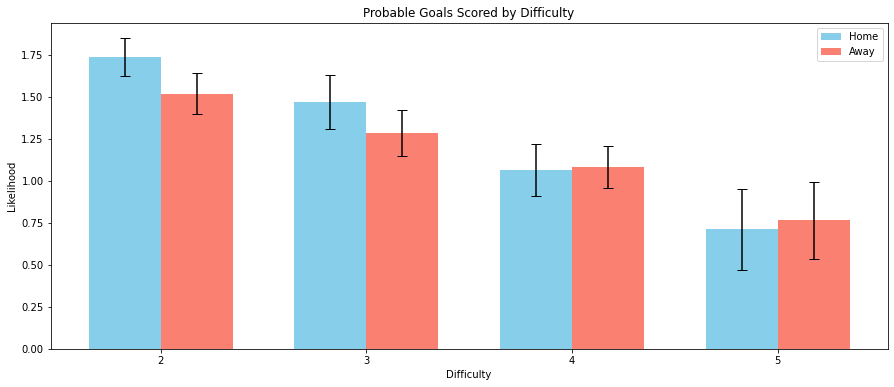

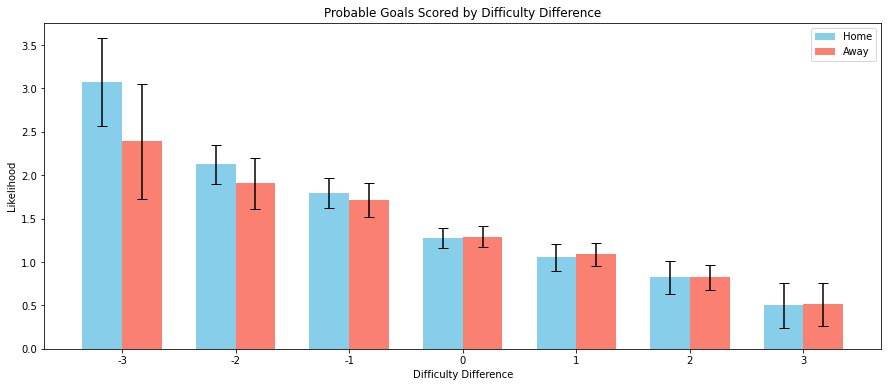

In [217]:
plot_bar_chart(clean_sheets_home_difficulty, clean_sheets_away_difficulty,  'Likelihood of Keeping a Clean Sheet by Difficulty', 'Difficulty', 'Likelihood')
plot_bar_chart(clean_sheets_home_difficulty_diff, clean_sheets_away_difficulty_diff,  'Likelihood of Keeping a Clean Sheet by Difficulty Difference', 'Difficulty Difference', 'Likelihood')
plot_bar_chart(goals_scored_home_difficulty, goals_scored_away_difficulty,  'Probable Goals Scored by Difficulty', 'Difficulty', 'Likelihood')
plot_bar_chart(goals_scored_home_difficulty_diff, goals_scored_away_difficulty_diff,  'Probable Goals Scored by Difficulty Difference', 'Difficulty Difference', 'Likelihood')

In [219]:
avg_points_home_away = stats.groupby('was_home')['total_points'].mean()
avg_points_by_difficulty = stats.groupby('difficulty')['total_points'].mean()
avg_points_by_difficulty_diff = stats.groupby('difficulty_difference')['total_points'].mean()

avg_points_home_away, avg_points_by_difficulty, avg_points_by_difficulty_diff

(was_home
 False    1.179892
 True     1.298920
 Name: total_points, dtype: float64,
 difficulty
 2    1.400953
 3    1.203062
 4    1.054534
 5    0.805326
 Name: total_points, dtype: float64,
 difficulty_difference
 -3    2.048780
 -2    1.632087
 -1    1.455160
  0    1.213329
  1    1.020974
  2    0.899112
  3    0.687175
 Name: total_points, dtype: float64)

<AxesSubplot:xlabel='difficulty_difference'>

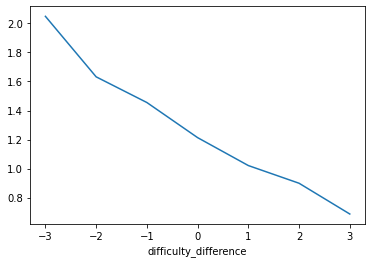

In [222]:
avg_points_by_difficulty_diff.plot()

<AxesSubplot:xlabel='difficulty'>

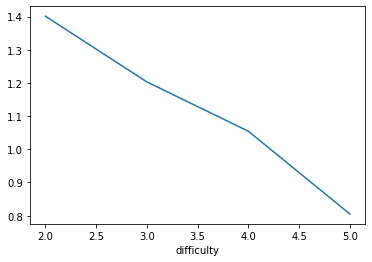

In [225]:
avg_points_by_difficulty.plot()